<div class="alert alert-success">
    <strong>Please note:</strong> This notebook is no longer working, because it used the module <code>xcube_sh.geodb</code> 
    which is no longer reported and hence has been removed. We'll update this Notebook soon with respect to the 
    actual <a href="https://github.com/dcs4cop/xcube-geodb">xcube-geodb</a> package.
</div>

# Example 4 - Using xcube with a geographic data base

This notebook shows how to access different data sets through the Sentinel Hub API:

1. Query DCFS GeoDB service to retrieve vector data set
2. Rasterize vector data
3. (Relate vector data and gridded data retrieved through Sentinel Hub)

To run this Notebook, make sure the Sentinel Hub / xcube Integration is setup correctly, see [Ex0-DCFS-Setup](./Ex0-DCFS-Setup.ipynb).

In [1]:
# xcube / SENTINEL Integration
from xcube_sh.config import CubeConfig
from xcube_sh.cube import open_cube
from xcube_sh.sentinelhub import SentinelHub
from xcube_sh.geodb import get_geo_db_service
# xcube Tools
from xcube.core.geom import rasterize_features
# Utilities
import xarray as xr
import numpy as np
import functools
import pyproj
import shapely.geometry
import shapely.ops
import IPython.display

We use [epsg:3794](https://epsg.io/3794) coordinates:

In [2]:
x1 = 450000  # meters
y1 = 90000  # meters
x2 = 470000  # meters
y2 = 110000  # meters

bbox_3794 = x1, y1, x2, y2

In [3]:
def transf(geometry, src='epsg:3794', dst='epsg:4326', reverse=False):
    project = functools.partial(
        pyproj.transform,
        pyproj.Proj(init=dst if reverse else src),
        pyproj.Proj(init=src if reverse else dst))
    return shapely.ops.transform(project, geometry)

In [4]:
spatial_res = (x2 - x1) / 512  # degrees
geom_wgs84 = transf(shapely.geometry.box(*bbox_3794))
bbox_wgs84 = geom_wgs84.bounds
IPython.display.GeoJSON(geom_wgs84.__geo_interface__)

<IPython.display.GeoJSON object>

In [5]:
cube_config = CubeConfig(dataset_name='S2L2A',
                         band_names=['B04'],
                         tile_size=[512, 512],
                         bbox=bbox_3794,
                         crs='http://www.opengis.net/def/crs/EPSG/0/3794',
                         spatial_res=spatial_res,
                         time_range=['2019-05-01', '2019-07-01'],
                         time_period='2D')  

In [6]:
cube = open_cube(cube_config)
cube

<xarray.Dataset>
Dimensions:    (bnds: 2, time: 31, x: 512, y: 512)
Coordinates:
  * time       (time) datetime64[ns] 2019-05-02 2019-05-04 ... 2019-07-01
    time_bnds  (time, bnds) datetime64[ns] dask.array<chunksize=(31, 2), meta=np.ndarray>
  * x          (x) float64 4.5e+05 4.501e+05 4.501e+05 ... 4.699e+05 4.7e+05
  * y          (y) float64 1.1e+05 1.099e+05 1.099e+05 ... 9.006e+04 9.002e+04
Dimensions without coordinates: bnds
Data variables:
    B04        (time, y, x) float32 dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
Attributes:
    Conventions:               CF-1.7
    title:                     S2L2A Data Cube Subset
    history:                   [{'program': 'xcube_sh.chunkstore.SentinelHubC...
    date_created:              2020-11-17T15:15:31.035821
    processing_level:          L2A
    time_coverage_start:       2019-05-01T00:00:00+00:00
    time_coverage_end:         2019-07-02T00:00:00+00:00
    time_coverage_duration:    P62DT0H0M0S
    time_coverage_resolution:  P2DT0H0M0S

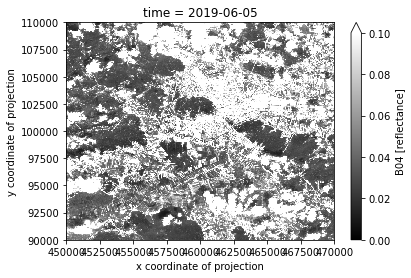

In [7]:
cube.B04.isel(time=17).plot.imshow(cmap='gray', vmin=0, vmax=0.1)

Get the DCFS GeoDB service:

In [8]:
geo_db = get_geo_db_service(driver='pgsql', host="",
            user="",
            password="")

OperationalError: could not translate host name "port=5432" to address: Unknown host


The current user's feature collections:

In [ ]:
geo_db.collections

Find features in collection `land_use` for our bounding box:

In [ ]:
features = geo_db.find_features(collection_name='land_use', bbox=bbox_3794, bbox_srid=3794)
features

Rasterise feature properties into cube:

In [ ]:
cube2 = rasterize_features(cube, features, ['raba_id'])

In [ ]:
cube2

In [ ]:
cube2.raba_id.plot.imshow(figsize=(16, 16))